In [3]:
!date

Mon Feb 26 12:07:07 EST 2024


In [4]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

In [5]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy.spatial.distance import pdist,squareform
from rsa_funcs import fit_rsa,make_RDM,get_triu
from tqdm import tqdm
from sklearn.cluster import KMeans

In [6]:
analyses = [a for a in os.listdir('../scratch/') if not a.startswith('.')]
analyses = np.array(analyses)
created_date = np.array([os.stat((os.path.join('../scratch/',analysis))).st_mtime for analysis in analyses])
created_date = np.argsort(created_date)[::-1]
#analyses.sort()
analyses = analyses[created_date]

def check_done(analysis_name):
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_1')):
        n1 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_1')) if f.startswith('varexp_attmp')])
    else:
        n1 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_2')):
        n2 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_2')) if f.startswith('varexp_attmp')])
    else:
        n2 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_3')):
        n3 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_3')) if f.startswith('varexp_attmp')])
    else:
        n3 = 0
    
    print(f'{analysis_name} {n1} {n2} {n3}')

[check_done(analysis_name) for analysis_name in analyses];


CVAE-5type-new2-N1000-YgKpqHLsbP 46 20 0
CVAE-5type-new2-N1000-QMdgkERhZu 49 20 0
CVAE-5type-new2-N1000-HigqUEMwsv 48 20 0
CVAE-5type-new2-N1000-nruquYmakm 46 20 0
CVAE-5type-new2-N1000-VOLeHEZiKM 45 20 0
CVAE-5type-new8-N1000-WNSmHdJfHp 47 20 0
CVAE-5type-new8-N1000-OBeOSwOKAx 0 0 0
CVAE-5type-new8-N1000-jrztwaTlcz 0 0 0
CVAE-5type-new8-N1000-oLcrhaGxfz 0 0 0
CVAE-5type-new8-N1000-nDacvOYHUM 0 0 0
CVAE-5type-new8-N1000-lxZdNNaOmT 0 0 0
CVAE-5type-new8-N1000-JQZZGGEDIe 44 1 0
CVAE-5type-new8-N1000-BuRaiOFEKc 44 20 0
CVAE-5type-new8-N1000-QVofYHFBwC 44 20 0
CVAE-5type-new8-kEbhwNpjgG 43 20 0
CVAE-5type-new8-sKddDMKpyI 43 20 0
CVAE-5type-new8-FGuTWrFkZi 46 20 0
CVAE-5type-new8-XsGkLzfAsQ 46 20 0
CVAE-5type-new8-N1000-yLeguXNthA 47 20 0
CVAE-5type-new8-N1000-CKSrNZbPPj 45 20 0
CVAE-5type-8D-old-N500-MrwoSoQWHR 44 20 0
CVAE-5type-new8-zzzygCizHs 47 20 0
CVAE-5type-new-npHGGDKsAY 48 20 0
CVAE-5type-new-zQzspLVHLH 49 20 0
CVAE-5type-new-SEOUWNcwrP 49 20 0
CVAE-5type-new-buzzKzmTxr 45 20 0
VA

In [7]:
def get_descriptive(vec):
    vec = np.array(vec)
    #print(f'M = {vec.mean():.2f}, SD = {vec.std():.2f}, range {vec.min():.2f}-{vec.max():.2f}')
    print(f'M = {np.nanmean(vec):.2f}, SD = {np.nanstd(vec):.2f}, range {np.nanmin(vec):.2f}-{np.nanmax(vec):.2f}')

In [8]:
def pretty_t_1sample(vec,popmean):
    from scipy.stats import ttest_1samp
    t,p = ttest_1samp(vec,popmean,alternative='two-sided')
    if p < .001:
        print(f't({len(vec)-1}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec)-1}) = {t:.2f}, p = {p:.3f}')

In [9]:
# def pretty_t_ind(vec1,vec2):
#     from scipy.stats import ttest_indd
#     t,p = ttest_ind(vec1,vec2)
    
#     if p < .001:
#         print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
#     else:
#         print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

def pretty_t_ind(vec1,vec2):
    from scipy.stats import ttest_ind
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    d = vec1.mean()-vec2.mean()
    #t,p = ttest_ind(vec1,vec2)
    t,p = ttest_ind(fisher_z(vec1),fisher_z(vec2))
    
    if p < .001:
        print(f'Δ={d:.2f}, t({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
    else:
        print(f'Δ={d:.2f}, t({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

In [10]:
def plot_scatters(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    
    plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    for r in range(s_latents.shape[0]):
        plt.subplot(1,s_latents.shape[0],r+1)
        for i in range(n_subtypes):
            plt.scatter(pc_comps[r][subtype_5==i+1,0],pc_comps[r][subtype_5==i+1,1],color=np.array(colors[i])/255)
        plt.title(f'repetition {r+1}')
        plt.legend(np.unique(subtype_5))


def plot_scatter(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    #pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]
    pc_comps = PCA(n_components=2).fit_transform(s_latents[0,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) )

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
    
    #plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    plt.figure(figsize=(5,5))
    r = 0
    #for r in range(s_latents.shape[0]):
    #plt.subplot(1,s_latents.shape[0],r+1)
    for i in range(n_subtypes):
        plt.scatter(pc_comps[subtype_5==i+1,0],pc_comps[subtype_5==i+1,1],color=np.array(colors[i])/255)
    #plt.title(f'repetition {r+1}')
    plt.legend(np.unique(subtype_5))
    plt.xlabel('PC 1 (a.u)')
    plt.ylabel('PC 2 (a.u)')


In [11]:
from numpy import arctanh as fisher_z # https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau

def fit_rsa(rdm_data,rdm_model,metric='kendalltau'):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)

    if metric=='kendalltau':
        #print('metric==kendalltau') 
        return kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif metric=='pearsonr':
        #print('metric==pearsonr') 
        return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    else:
        print('not implemented, wtf')
        return np.nan
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec

from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def get_clustering_acc(mat,subtype,n_components=2):
    #c_ = GaussianMixture(n_components=n_components).fit_predict(mat)
    c_ = KMeans(n_clusters=n_components).fit_predict(mat)
    return adjusted_rand_score(c_,subtype)

In [12]:
def get_vae_res(analyses,data_csv_fn):
    #data_csv_fn = '../Data/synth-data-02.csv'
    #data_csv_fn = '../Data/synth-data-02-N1000.csv'
    #data_csv_fn = '../Data/synth-data-02.csv'
    #data_csv_fn = '../Data/synth-data-01-N500.csv'
    
    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    subtype = df['subtype'].values[patient_idx]
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    #analyses = ['VAE_uHobWzHSMC','VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr'] # VAE N=2000
    #analyses = ['VAE_2type_N1000XqPxAUfMDb','VAE_2type_N1000rNGtnKsnGq','VAE_2type_N1000kHBOoowhQG','VAE_2type_N1000uBZSdHlQQc','VAE_2type_N1000PnRPePktJT'] # VAE N=1000
    
    vae_varexps = []
    vae_varexps_m = []
    latents = []
    
    #analysis = analyses[0]
    for analysis in analyses:
        training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
        training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
        varexp = [training_log['varExps'][-1] for training_log in training_logs]
        varexp = np.array(varexp)
        
        vae_varexps.append( varexp )
        vae_varexps_m.append( varexp.mean() )
        latents.append( [training_log['l_patients'] for training_log in training_logs] )
    
    latents = np.array(latents)
    vae_varexps = np.array(vae_varexps)
    vae_varexps_m = np.array(vae_varexps)
    
    vae_c_acc_indiv = []
    for i in range( latents.shape[0] ):
            vae_c_acc_indiv.append( [get_clustering_acc(latents[i,j,:,:],subtype) for j in range( latents.shape[1] )])
    vae_c_acc_indiv = np.array(vae_c_acc_indiv)
    
    vae_features_stacked = np.array([np.hstack([latents[j,i,:,:] for i in range(latents.shape[1])]) for j in range(latents.shape[0])])
    vae_c_acc_ens = [get_clustering_acc(vae_features_stacked[i,:,:],subtype) for i in range(vae_features_stacked.shape[0])]
    
    res_vae = {}
    res_vae['subtype'] = subtype
    res_vae['latents'] = latents
    res_vae['latents_stacked'] = vae_features_stacked
    res_vae['varexps'] = vae_varexps
    res_vae['varexps_m'] = vae_varexps_m
    res_vae['c_acc_indiv'] = vae_c_acc_indiv
    res_vae['c_acc_ens'] = np.array(vae_c_acc_ens)
    
    [print(f'{key} | {res_vae[key].shape}') for key in list(res_vae.keys())];

    return res_vae

In [13]:

vae_res_N1000 = get_vae_res(analyses=['VAE_2type_N1000XqPxAUfMDb','VAE_2type_N1000rNGtnKsnGq','VAE_2type_N1000kHBOoowhQG','VAE_2type_N1000uBZSdHlQQc','VAE_2type_N1000PnRPePktJT'],data_csv_fn = '../Data/synth-data-02-N1000.csv')


subtype | (500,)
latents | (5, 20, 500, 4)
latents_stacked | (5, 500, 80)
varexps | (5, 20)
varexps_m | (5, 20)
c_acc_indiv | (5, 20)
c_acc_ens | (5,)


In [14]:

vae_res_N2000 = get_vae_res(analyses=['VAE_uHobWzHSMC','VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr'],data_csv_fn = '../Data/synth-data-02.csv')


subtype | (1000,)
latents | (5, 18, 1000, 4)
latents_stacked | (5, 1000, 72)
varexps | (5, 18)
varexps_m | (5, 18)
c_acc_indiv | (5, 18)
c_acc_ens | (5,)


In [15]:
get_descriptive(vae_res_N1000['c_acc_ens'])

M = 0.10, SD = 0.00, range 0.09-0.11


In [16]:
get_descriptive(vae_res_N2000['c_acc_ens'])

M = 0.10, SD = 0.01, range 0.09-0.11


In [17]:
pretty_t_1sample(vae_res_N1000['c_acc_ens'],.0)

t(4) = 43.03, p < .001


In [18]:
pretty_t_1sample(vae_res_N2000['c_acc_ens'],.0)

t(4) = 26.78, p < .001


In [19]:
#plot_scatter(res_vae['latents'][:,:,np.newaxis,:,:],data_csv_fn='../Data/synth-data-02.csv')
#plot_scatter(res_vae['latents'][:,:,np.newaxis,:,:],data_csv_fn='../Data/synth-data-02-N1000.csv')

In [20]:
# pcs = PCA(n_components=2).fit_transform(res_vae['latents_stacked'][0,:,:])
# c = GaussianMixture(n_components=2).fit_predict(res_vae['latents_stacked'][0,:,:])

In [21]:
# plt.figure(figsize=(5,5))
# plt.scatter(pcs[subtype==1,0],pcs[subtype==1,1],c=np.array([252,225,67])/255,alpha=.5)
# plt.scatter(pcs[subtype==2,0],pcs[subtype==2,1],c=np.array([76,21,72])/255,alpha=.5)
# plt.xticks([])
# plt.yticks([])
# #plt.xlabel('PC 1 (a.u)')
# #plt.ylabel('PC 2 (a.u)')

In [22]:
# plt.figure(figsize=(5,5))
# plt.scatter(pcs[c==0,0],pcs[c==0,1],c=np.array([255,193,124])/255)
# plt.scatter(pcs[c==1,0],pcs[c==1,1],c=np.array([0,0,0])/255)
# plt.xticks([])
# plt.yticks([])

In [23]:
#analyses = ['2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-8DqULkbZtaFi','2type-QzJmjkwddT','2type-ImTsKjutaD','2type-yvdvqaCvSX',]
def get_cvae_res(analyses,data_csv_fn = '../Data/synth-data-02.csv'):
    #data_csv_fn = '../Data/synth-data-02.csv'
    #data_csv_fn = '../Data/synth-data-01-N500.csv'
    
    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    subtype = df['subtype'].values[patient_idx]
    n_subtypes = len(np.unique(subtype))
    print(n_subtypes)
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    s_latents = []
    z_latents = []
    cvae_varexps = []
    cvae_varexps_m = []
    
    for analysis in analyses:
        training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
        training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
        varexp = [training_log['varExps'][-1] for training_log in training_logs]
        varexp = np.array(varexp)
        
        cvae_varexps.append( varexp )
        cvae_varexps_m.append( varexp.mean() )
        s_latents.append( [training_log['s_patients'] for training_log in training_logs] )
        z_latents.append( [training_log['z_patients'] for training_log in training_logs] )
    
    
    s_latents = np.array(s_latents)
    cvae_c_acc_indiv = []
    for i in range( s_latents.shape[0] ):
            cvae_c_acc_indiv.append( [get_clustering_acc(s_latents[i,j,-1,:,:],subtype,n_components=n_subtypes) for j in range( s_latents.shape[1] )])
    cvae_c_acc_indiv = np.array(cvae_c_acc_indiv)

    s_latents_stacked = np.array([np.hstack([s_latents[j,i,-1,:] for i in range(s_latents.shape[1])]) for j in range(s_latents.shape[0])])
    c_acc_ens = [get_clustering_acc(s_latents_stacked[i,:,:],subtype,n_components=n_subtypes) for i in range(s_latents_stacked.shape[0])]
    
    res_cvae = {}
    res_cvae['subtype'] = subtype
    res_cvae['varexps'] = np.array(cvae_varexps)
    res_cvae['varexps_m'] = np.array(cvae_varexps_m)
    res_cvae['s_latents'] = np.array(s_latents)
    res_cvae['z_latents'] = np.array(z_latents)
    res_cvae['c_acc_indiv'] = np.array(cvae_c_acc_indiv)
    #res_cvae['c_acc_ens'] = res_cvae['c_acc_indiv'].mean(axis=1)
    res_cvae['s_latents_stacked'] = s_latents_stacked
    res_cvae['c_acc_ens'] = np.array(c_acc_ens)
    #res_cvae[''] = 
    return res_cvae

In [24]:
res_cvae_N1000 = get_cvae_res( ['2type-N1000-SsAkmZgMEg','2type-N1000-jgaXcHvlrU','2type-N1000-yVufeEzKhJ','2type-N1000-lNlPUEKniS','2type-N1000-RyexWBHBsC',],data_csv_fn = '../Data/synth-data-02-N1000.csv')

2


In [25]:
res_cvae_N2000 = get_cvae_res(['2type-ImTsKjutaD','2type-yvdvqaCvSX','2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-QzJmjkwddT'],data_csv_fn = '../Data/synth-data-02.csv')

2


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [26]:

res_cvae_3typeN2000 = get_cvae_res(['CVAE-3type-RpjbVewTkF','CVAE-3type-COlRaiafwG','CVAE-3type-rxbrpNgKNC','CVAE-3type-cjDXIoxZHB','CVAE-3type-YAjYFtDAep'],data_csv_fn = '../synth-data-03/data_description.csv')


3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [27]:
res_cvae_3type_N1000 = get_cvae_res(['CVAE-3type-N500hmmrUxrGIt','CVAE-3type-N500pAJEYZHjYj','CVAE-3type-N500gYGEfcZxDC','CVAE-3type-N500OoREXdpler','CVAE-3type-N500XwLMaIGLLd'],data_csv_fn = '../Data/synth-data-03-N1000.csv')

3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [28]:
# Only 3 finished, add later
#res_cvae_5type_N1000_2D = get_cvae_res(['CVAE-5type-new2-N1000-YgKpqHLsbP','CVAE-5type-new2-N1000-QMdgkERhZu','CVAE-5type-new2-N1000-HigqUEMwsv','CVAE-5type-new2-N1000-nruquYmakm','CVAE-5type-new2-N1000-VOLeHEZiKM'],data_csv_fn = '../Data/synth-data-05new-N1000.csv')

res_cvae_5type_N2000_2D = get_cvae_res(['CVAE-5type-dTkDjgdfxL','CVAE-5type-iAiIvvxnyA','CVAE-5type-HyABYkiDmv','CVAE-5type-uLtXBzUGUc','CVAE-5type-IFVZazjuWp'],data_csv_fn = '../synth-data-05/data_description.csv')


5


In [29]:

res_cvae_5type_N1000_2D = get_cvae_res(['CVAE-5type-N1000-zHXfpElhZf','CVAE-5type-N1000-bGwnoafftJ','CVAE-5type-N1000-gYdpyQdCzh','CVAE-5type-N1000-cleHmpYSXk','CVAE-5type-N1000-bCxBTltyKJ'],data_csv_fn = '../Data/synth-data-05-N1000.csv')


5


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to d

In [30]:
print(res_cvae_5type_N1000_2D['s_latents'].shape)
print(res_cvae_5type_N2000_2D['s_latents'].shape)

(5, 20, 100, 500, 2)
(5, 20, 100, 1000, 2)


In [31]:
#res_cvae_5type_N1000_8D = get_cvae_res(['CVAE-5type-new8-N1000-WNSmHdJfHp','CVAE-5type-new8-N1000-BuRaiOFEKc','CVAE-5type-new8-N1000-QVofYHFBwC','CVAE-5type-new8-N1000-yLeguXNthA','CVAE-5type-new8-N1000-CKSrNZbPPj'],data_csv_fn = '../Data/synth-data-05new-N1000.csv')


In [32]:
#res_cvae_5type_N2000_8D = get_cvae_res(['CVAE-5type-new8-kEbhwNpjgG','CVAE-5type-new8-sKddDMKpyI','CVAE-5type-new8-FGuTWrFkZi','CVAE-5type-new8-XsGkLzfAsQ','CVAE-5type-new8-zzzygCizHs'],data_csv_fn = '../synth-data-05/data_description.csv')


### VAE/CVAE Scatterplots for Fig 01

In [165]:
print(vae_res_N1000.keys())
print(res_cvae_N1000.keys())

dict_keys(['subtype', 'latents', 'latents_stacked', 'varexps', 'varexps_m', 'c_acc_indiv', 'c_acc_ens'])
dict_keys(['subtype', 'varexps', 'varexps_m', 's_latents', 'z_latents', 'c_acc_indiv', 's_latents_stacked', 'c_acc_ens'])


In [174]:
i = 0
vae_space = vae_res_N1000['latents_stacked'][i,:,:]
cvae_space = res_cvae_N1000['s_latents_stacked'][i,:,:]
z_latents_stacked = res_cvae_N1000['s_latents'][i,:,-1,:,:].reshape(500,-1)
print(vae_space.shape)
print(cvae_space.shape)

(500, 80)
(500, 40)


In [175]:
C = np.array([int(np.mod(i,2)!=0) for i in range(500)])

In [176]:
pcs_vae_space = PCA(n_components=2).fit_transform(vae_space)
pcs_cvae_s_space = PCA(n_components=2).fit_transform(cvae_space)
pcs_cvae_z_space = PCA(n_components=2).fit_transform(z_latents_stacked)

In [177]:
colors = [np.array((225,228,61))/255,np.array((66,12,72))/255]
colors = [np.array((225,225,0))/255,np.array((66,12,72))/255]
colors

[array([0.88235294, 0.88235294, 0.        ]),
 array([0.25882353, 0.04705882, 0.28235294])]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

([<matplotlib.axis.YTick at 0x1554f6ee6d60>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

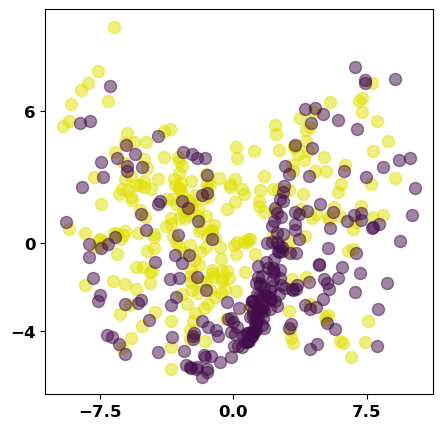

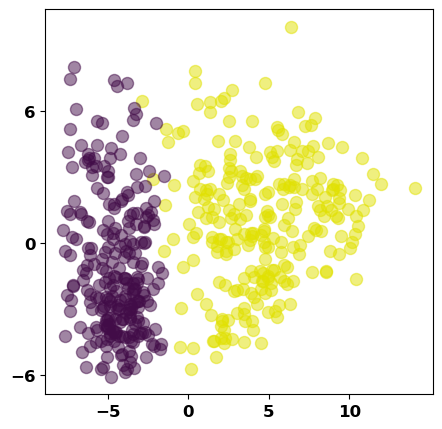

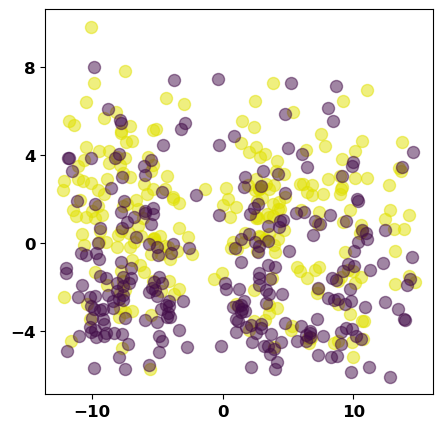

In [178]:
#plt.figure(figsize=(15,5))
#plt.subplot(1,3,1)
plt.figure(figsize=(5,5))
plt.scatter(pcs_vae_space[C==0,0],pcs_vae_space[C==0,1],c=colors[0],alpha=.5,s=75)
plt.scatter(pcs_vae_space[C==1,0],pcs_vae_space[C==1,1],c=colors[1],alpha=.5,s=75)
plt.xticks([-7.5,0,7.5],fontsize=12,fontweight='bold')
plt.yticks([-4,0,6],fontsize=12,fontweight='bold')

#plt.subplot(1,3,2)
plt.figure(figsize=(5,5))
plt.scatter(pcs_cvae_s_space[C==0,0],pcs_vae_space[C==0,1],c=colors[0],alpha=.5,s=75)
plt.scatter(pcs_cvae_s_space[C==1,0],pcs_vae_space[C==1,1],c=colors[1],alpha=.5,s=75)
plt.xticks([-5,0,5,10],fontsize=12,fontweight='bold')
plt.yticks([-6,0,6],fontsize=12,fontweight='bold')

#plt.subplot(1,3,3)
plt.figure(figsize=(5,5))
plt.scatter(pcs_cvae_z_space[C==0,0],pcs_vae_space[C==0,1],c=colors[0],alpha=.5,s=75)
plt.scatter(pcs_cvae_z_space[C==1,0],pcs_vae_space[C==1,1],c=colors[1],alpha=.5,s=75)
plt.xticks([-10,0,10],fontsize=12,fontweight='bold')
plt.yticks([-4,0,4,8],fontsize=12,fontweight='bold')

In [172]:
colors = [np.array((255,193,124))/255,np.array((0,0,0))/255]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

([], [])

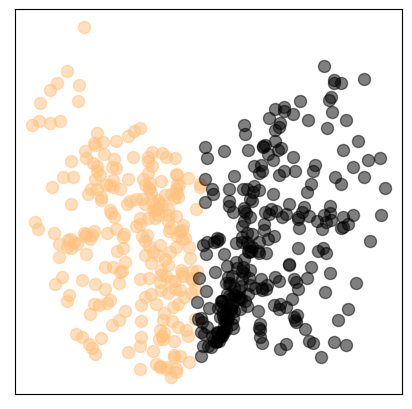

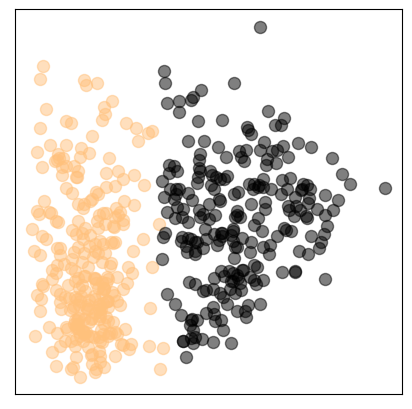

In [173]:
#plt.figure(figsize=(15,5))
#plt.subplot(1,3,1)
plt.figure(figsize=(5,5))
C = KMeans(n_clusters=2).fit_predict(pcs_vae_space)
plt.scatter(pcs_vae_space[C==0,0],pcs_vae_space[C==0,1],c=colors[0],alpha=.5,s=75)
plt.scatter(pcs_vae_space[C==1,0],pcs_vae_space[C==1,1],c=colors[1],alpha=.5,s=75)
plt.xticks([])
plt.yticks([])

#plt.subplot(1,3,2)
plt.figure(figsize=(5,5))
C = KMeans(n_clusters=2).fit_predict(pcs_cvae_s_space)
plt.scatter(pcs_cvae_s_space[C==0,0],pcs_vae_space[C==0,1],c=colors[0],alpha=.5,s=75)
plt.scatter(pcs_cvae_s_space[C==1,0],pcs_vae_space[C==1,1],c=colors[1],alpha=.5,s=75)
plt.xticks([])
plt.yticks([])

### Clsutering accuracy stats

In [31]:
# vae_res_N1000
# vae_res_N2000
# res_cvae_N1000
# res_cvae_N2000
# res_cvae_3type_N1000
# res_cvae_3typeN2000
# res_cvae_5type_N2000_2D
# res_cvae_5type_N1000_2D

In [32]:
vae_res_N1000.keys()

dict_keys(['subtype', 'latents', 'latents_stacked', 'varexps', 'varexps_m', 'c_acc_indiv', 'c_acc_ens'])

In [33]:
res_cvae_N1000.keys()

dict_keys(['subtype', 'varexps', 'varexps_m', 's_latents', 'z_latents', 'c_acc_indiv', 's_latents_stacked', 'c_acc_ens'])

In [34]:
print('VAE N=1000, individual accuracy')
get_descriptive(vae_res_N1000['c_acc_indiv'])

VAE N=1000, individual accuracy
M = 0.11, SD = 0.05, range -0.00-0.29


In [35]:
print('VAE N=1000, enseble accuracy')
get_descriptive(vae_res_N1000['c_acc_ens'])

VAE N=1000, enseble accuracy
M = 0.10, SD = 0.00, range 0.09-0.11


In [36]:
print('CVAE N=1000, individual accuracy')
get_descriptive(res_cvae_N1000['c_acc_indiv'])

CVAE N=1000, individual accuracy
M = 0.51, SD = 0.22, range -0.00-0.98


In [37]:
print('CVAE N=1000, enseble accuracy')
get_descriptive(res_cvae_N1000['c_acc_ens'])

CVAE N=1000, enseble accuracy
M = 0.79, SD = 0.05, range 0.71-0.88


In [38]:
print('CVAE > VAE N1000')
pretty_t_ind(res_cvae_N1000['c_acc_ens'],vae_res_N1000['c_acc_ens'])

CVAE > VAE N1000
Δ=0.69, t(8) = 13.10, p < .001


In [39]:
print('CVAE 2 > CVAE 3')
print(res_cvae_N1000['c_acc_ens'].mean().round(2))
print(res_cvae_3type_N1000['c_acc_ens'].mean().round(2))
pretty_t_ind(res_cvae_N1000['c_acc_ens'],res_cvae_3type_N1000['c_acc_ens'])

CVAE 2 > CVAE 3
0.79
0.53
Δ=0.26, t(8) = 6.55, p < .001


In [40]:
print('CVAE 2 > CVAE 3')
print(res_cvae_3type_N1000['c_acc_ens'].mean().round(2))
print(res_cvae_5type_N1000_2D['c_acc_ens'].mean().round(2))
pretty_t_ind(res_cvae_3type_N1000['c_acc_ens'],res_cvae_5type_N1000_2D['c_acc_ens'])

CVAE 2 > CVAE 3
0.53
0.28
Δ=0.25, t(8) = 24.12, p < .001


In [41]:
print('CVAE > VAE N1000')
pretty_t_ind(res_cvae_N1000['c_acc_ens'],vae_res_N1000['c_acc_ens'])

CVAE > VAE N1000
Δ=0.69, t(8) = 13.10, p < .001


In [42]:
print('CVAE N2000 > N1000, 2 clusters')
pretty_t_ind(res_cvae_N2000['c_acc_ens'],res_cvae_N1000['c_acc_ens'])

CVAE N2000 > N1000, 2 clusters
Δ=0.11, t(8) = 3.98, p = 0.004


In [43]:
print('CVAE N2000 > N1000, 3 clusters')
pretty_t_ind(res_cvae_3typeN2000['c_acc_ens'],res_cvae_3type_N1000['c_acc_ens'])

CVAE N2000 > N1000, 3 clusters
Δ=0.16, t(8) = 10.57, p < .001


In [44]:
print('CVAE N2000 > N1000, 5 clusters')
pretty_t_ind(res_cvae_5type_N2000_2D['c_acc_ens'],res_cvae_5type_N1000_2D['c_acc_ens'])

CVAE N2000 > N1000, 5 clusters
Δ=0.28, t(8) = 24.68, p < .001


In [45]:
def plot_scatters(data):
    #data = res_cvae_3type_N1000
    latents = data['s_latents_stacked'][0,:,:]
    subtype = data['subtype']
    n_subtype = len(np.unique(subtype))
    
    pcs = PCA(n_components=2).fit_transform(latents)
    #c = GaussianMixture(n_components=n_subtype).fit_predict(latents)
    c = KMeans(n_clusters=n_subtype).fit_predict(latents)
    
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
    
    for i in range(n_subtype):
            plt.scatter(pcs[subtype==i+1,0],pcs[subtype==i+1,1],color=np.array(colors[i])/255,alpha=.5)
    
    plt.legend(np.unique(subtype))
    plt.xlabel('PC 1 (a.u)')
    plt.ylabel('PC 2 (a.u)')

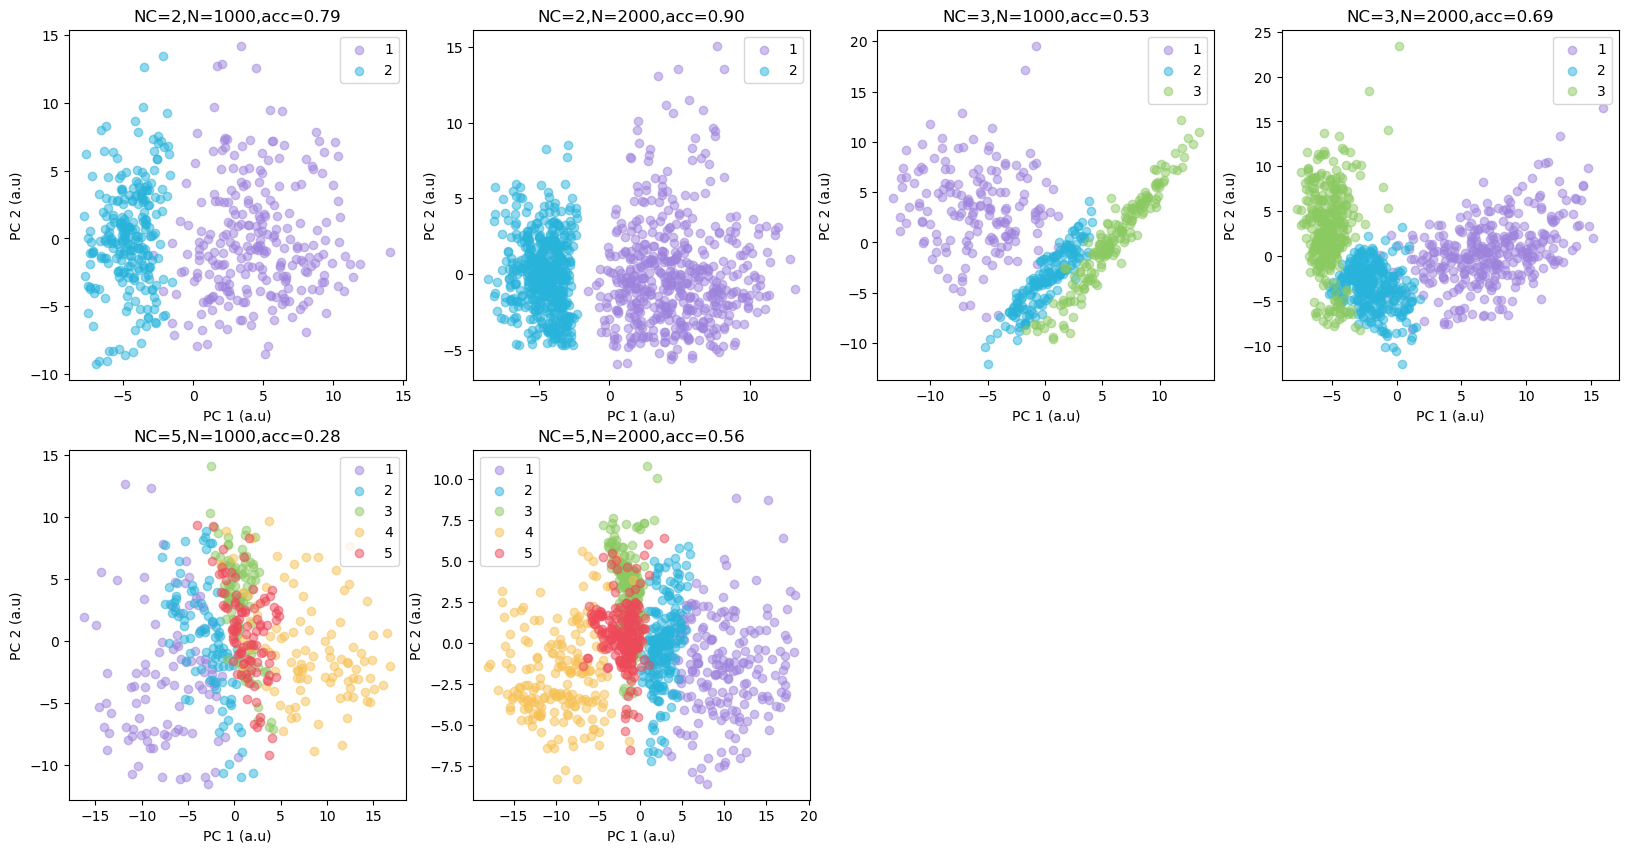

In [46]:
plt.figure(figsize=(20,10))
#datas = [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N1000_8D,res_cvae_5type_N2000_8D]
datas = [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N2000_2D]
for i in range(len(datas)):
    plt.subplot(2,4,i+1)
    plot_scatters(datas[i])
    plt.title('NC={},N={},acc={:.2f}'.format(len(np.unique(datas[i]['subtype'])),datas[i]['s_latents_stacked'].shape[1]*2,datas[i]['c_acc_ens'].mean()))

In [47]:
# [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N1000_8D,res_cvae_5type_N2000_8D]

In [48]:
acc_cvae_2C_N1000 = res_cvae_N2000['c_acc_ens']
acc_cvae_2C_N500 = res_cvae_N1000['c_acc_ens']

acc_cvae_3C_N1000 = res_cvae_3typeN2000['c_acc_ens']
acc_cvae_3C_N500 = res_cvae_3type_N1000['c_acc_ens']

acc_cvae_5C_N1000 = res_cvae_5type_N2000_2D['c_acc_ens']
acc_cvae_5C_N500 = res_cvae_5type_N1000_2D['c_acc_ens']

In [49]:
# print('M1={:.2f},M2={:.2f},ΔM={:.2f}'.format(acc_cvae_2C_N500.mean(),acc_cvae_3C_N500.mean(),acc_cvae_2C_N500.mean()-acc_cvae_3C_N500.mean()))
# print('M1={:.2f},M2={:.2f},ΔM={:.2f}'.format(acc_cvae_3C_N500.mean(),acc_cvae_5C_N500.mean(),acc_cvae_3C_N500.mean()-acc_cvae_5C_N500.mean()))

In [50]:
# pretty_t_ind(fisher_z(acc_cvae_2C_N500),fisher_z(acc_cvae_3C_N500))
# pretty_t_ind(fisher_z(acc_cvae_3C_N500),fisher_z(acc_cvae_5C_N500))

In [51]:
datas = [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N2000_2D]

[0.9034140332736582, 0.6857241253633181, 0.5624461636458562]


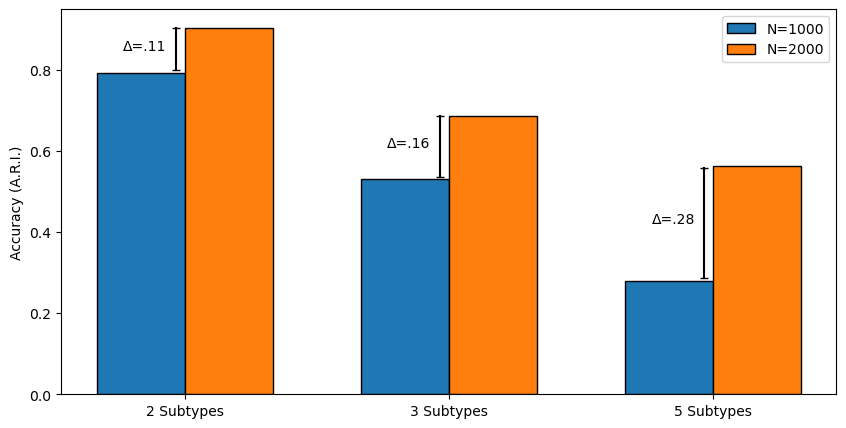

In [52]:
plt.figure(figsize=(10,5))
xs = [0,0.5, 1.5,2, 3,3.5]
#ys = [1,2,1,2,1,2]


# ys = [acc_cvae_2C_N500.mean(),
# acc_cvae_2C_N1000.mean(),
# acc_cvae_3C_N500.mean(),
# acc_cvae_3C_N1000.mean(),
# acc_cvae_5C_N500.mean(),
# acc_cvae_5C_N1000.mean()]
# plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0, 1.5, 3,]
ys = [acc_cvae_2C_N500.mean(),
acc_cvae_3C_N500.mean(),
acc_cvae_5C_N500.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0.5, 2, 3.5]
ys = [acc_cvae_2C_N1000.mean(),
acc_cvae_3C_N1000.mean(),
acc_cvae_5C_N1000.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

plt.legend(['N=1000','N=2000'])

plt.plot([3.2,3.2],[acc_cvae_5C_N500.mean()*1.03,acc_cvae_5C_N1000.mean()*.99],'k-_')

plt.plot([0.2,0.2],[acc_cvae_2C_N500.mean()*1.01,acc_cvae_2C_N1000.mean()*1.0],'k-_')
#delta = acc_cvae_2C_N500.mean()*1.03-acc_cvae_2C_N1000.mean()*.99
delta = acc_cvae_2C_N500.mean()-acc_cvae_2C_N1000.mean()
plt.text(-.10,acc_cvae_2C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.plot([1.7,1.7],[acc_cvae_3C_N500.mean()*1.01,acc_cvae_3C_N1000.mean()*1.0],'k-_')
#delta = acc_cvae_3C_N500.mean()*1.03-acc_cvae_3C_N1000.mean()*.99
delta = acc_cvae_3C_N500.mean()-acc_cvae_3C_N1000.mean()
plt.text(1.4,acc_cvae_3C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

#delta = acc_cvae_5C_N500.mean()*1.03-acc_cvae_5C_N1000.mean()*.99
delta = acc_cvae_5C_N500.mean()-acc_cvae_5C_N1000.mean()
plt.text(2.9,acc_cvae_5C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.xticks([.25,1.75,3.25],labels=['2 Subtypes','3 Subtypes','5 Subtypes'])
plt.ylabel('Accuracy (A.R.I.)')

print(ys)

In [53]:
# acc_cvae_2C_N1000 = res_cvae['c_acc_ens']
# acc_cvae_2C_N500 = res_cvae_N1000['c_acc_ens']

# acc_cvae_3C_N1000 = res_cvae_3typeN1000['c_acc_ens']
# acc_cvae_3C_N500 = res_cvae_3type_N500['c_acc_ens']

# acc_cvae_5C_N1000 = res_cvae_5type['c_acc_ens']
# acc_cvae_5C_N500 = res_cvae_5typeN1000['c_acc_ens']

#['varexps', 'varexps_m', 's_latents', 'z_latents', 'c_acc_indiv', 's_latents_stacked', 'c_acc_ens'])

In [54]:
# df_2_N2000 = pd.read_csv('../Data/synth-data-02.csv')
# df_2_N1000 = pd.read_csv('../Data/synth-data-02-N1000.csv')
# df_3_N2000 = pd.read_csv('../synth-data-03/data_description.csv')
# df_3_N1000 = pd.read_csv('../Data/synth-data-03-N1000.csv')
# df_5_N1000 = pd.read_csv('../Data/synth-data-05-N1000.csv')
# df_5_N2000 = pd.read_csv('../synth-data-05/data_description.csv')

# df = df_3_N1000
# arr = res_cvae_3typeN1000['s_latents_stacked']

def test_clustering_stability(data,do_plot=False):
    from sklearn.cluster import KMeans
    arr = data['s_latents_stacked'][0,:,:]
    #patients = df['dx'].values==1
    #controls = df['dx'].values==0
    subtype = data['subtype']
    #subtype = df['subtype'].values[patients]
    isubtypes = np.unique(subtype)
    nsubtypes = len(isubtypes)

    # print(arr.shape)
    # print(df.shape)
    # print(subtype.shape)
    
    pc_comps = PCA(n_components=2).fit_transform(arr)
    if do_plot:
        plt.figure(figsize=(3,3))
        for i in isubtypes:
            plt.scatter(pc_comps[subtype==i,0],pc_comps[subtype==i,1],alpha=.5)
        plt.legend(isubtypes)
    caccs = []
    if do_plot:
        plt.figure(figsize=(15,5))
    for i in range(10):
        #C = GaussianMixture(n_components=nsubtypes).fit_predict(arr)
        C = KMeans(n_clusters=nsubtypes).fit_predict(arr)
        caccs.append( adjusted_rand_score(subtype,C) )
        if do_plot:
            plt.subplot(2,5,i+1)
            for i in np.unique(C):
                plt.scatter(pc_comps[C==i,0],pc_comps[C==i,1],alpha=.2)
                plt.title('ADI={:.2f}'.format(adjusted_rand_score(subtype,C)))
            #plt.tight_layout()
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
    caccs = np.array(caccs)
    
    ndim = data['s_latents'].shape[-1]
    n = data['s_latents_stacked'][0,:,:].shape[0]
    delta = caccs.max()-caccs.min()
    print(f'{nsubtypes} subtypes, N={n*2}, NDIM:{ndim} : M={caccs.mean():.2f},SD={caccs.std():.2f},{caccs.min():.2f}-{caccs.max():.2f},ΔACC={delta:.2f}')

#arrs = [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N1000_8D,res_cvae_5type_N2000_8D]
arrs = [res_cvae_N1000,res_cvae_N2000,res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N2000_2D]

In [55]:
res_cvae_N1000.keys()

dict_keys(['subtype', 'varexps', 'varexps_m', 's_latents', 'z_latents', 'c_acc_indiv', 's_latents_stacked', 'c_acc_ens'])

In [56]:
def get_clust_rel(data,method='GMM'):
    latents = data['s_latents_stacked'][0,:,:]
    subtype = data['subtype']
    nsubtype = len(np.unique(subtype))
    if method=='GMM':
        Cs = [adjusted_rand_score(subtype,GaussianMixture(n_components=nsubtype).fit_predict(latents)) for _ in range(100)]
    elif method=='KM':
        Cs = [adjusted_rand_score(subtype,KMeans(n_clusters=nsubtype).fit_predict(latents)) for _ in range(100)]
    else:
        raise(Exception('WHAT'))
    return Cs

In [57]:
#arrs = [res_cvae_5type_N1000_2D,res_cvae_5type_N2000_2D,res_cvae_5type_N1000_8D,res_cvae_5type_N2000_8D]
#arrs = datas
arrs = [res_cvae_3type_N1000,res_cvae_3typeN2000,res_cvae_5type_N1000_2D,res_cvae_5type_N2000_2D]

In [58]:
rel_gmm = [get_clust_rel(data,method='GMM') for data in arrs]

In [59]:
rel_km = [get_clust_rel(data,method='KM') for data in arrs]

Text(0.5, 1.04, 'Stability: Gaussian Mixture Modelling')

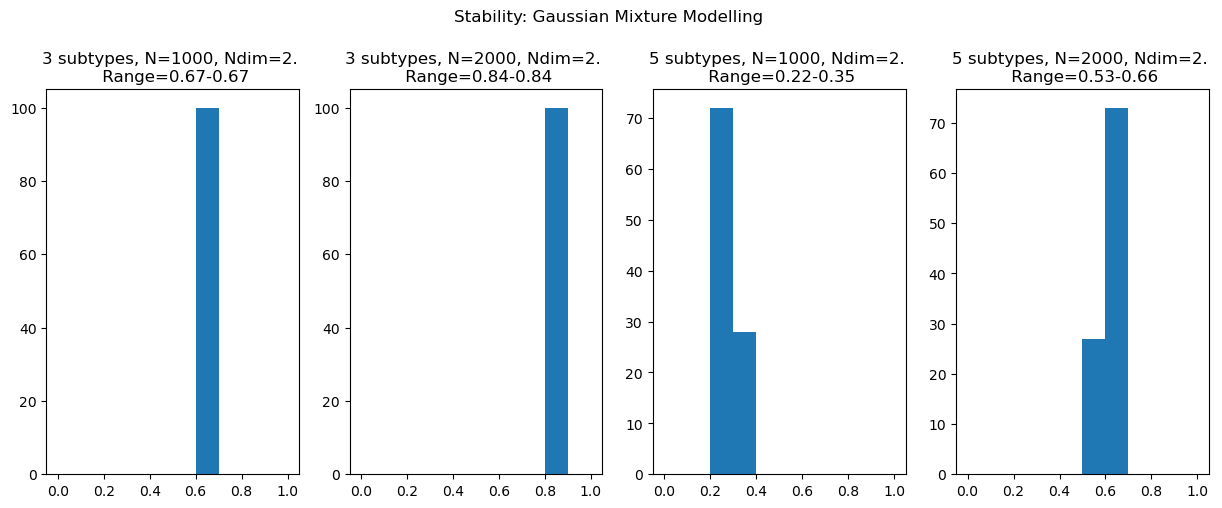

In [60]:
plt.figure(figsize=(15,5))
for i in range(len(arrs)):
    plt.subplot(1,len(arrs),i+1)
    data = arrs[i]
    ndim = data['s_latents'].shape[-1]
    n = data['s_latents_stacked'].shape[1]
    nsubtype = len(np.unique(data['subtype']))
    plt.hist(rel_gmm[i],range=[0,1])
    plt.title(f'{nsubtype} subtypes, N={n*2}, Ndim={ndim}. \n Range={np.array(rel_gmm[i]).min():.2f}-{np.array(rel_gmm[i]).max():.2f}')
plt.suptitle('Stability: Gaussian Mixture Modelling',y=1.04)

Text(0.5, 1.04, 'Stability: Kmeans')

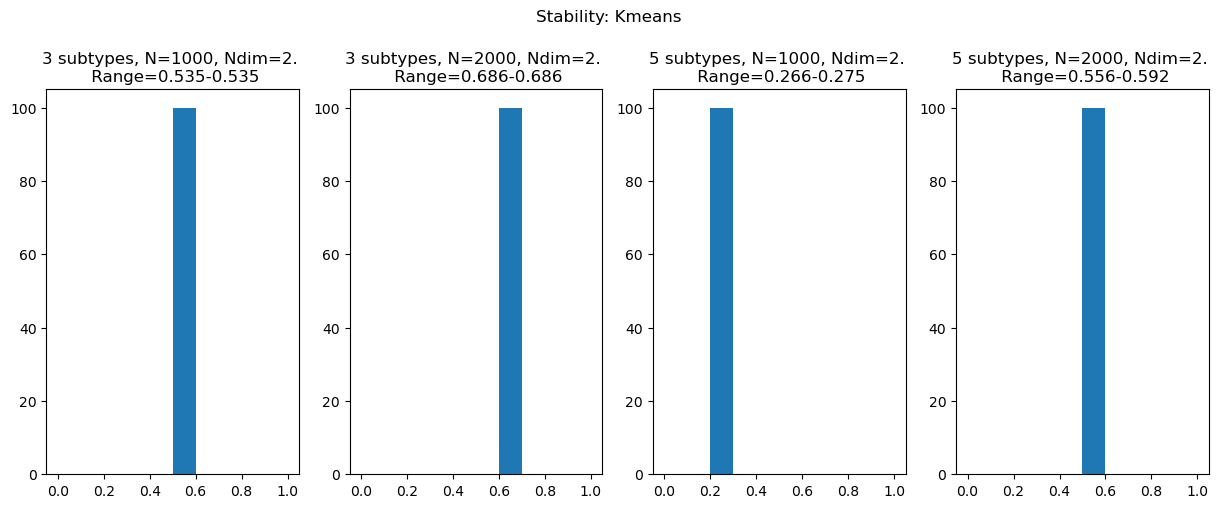

In [61]:
plt.figure(figsize=(15,5))
for i in range(len(arrs)):
    plt.subplot(1,len(arrs),i+1)
    data = arrs[i]
    ndim = data['s_latents'].shape[-1]
    n = data['s_latents_stacked'].shape[1]
    nsubtype = len(np.unique(data['subtype']))
    
    plt.hist(rel_km[i],range=[0,1])
    plt.title(f'{nsubtype} subtypes, N={n*2}, Ndim={ndim}. \n Range={np.array(rel_km[i]).min():.3f}-{np.array(rel_km[i]).max():.3f}')

plt.suptitle('Stability: Kmeans',y=1.04)

In [62]:
# data = res_cvae_5type_N2000_8D
# ns = len(np.unique(data['subtype']))
# #accs = [adjusted_rand_score(data['subtype'],GaussianMixture(n_components=ns).fit_predict(data['s_latents_stacked'][0,:,:])) for i in range(100)]
# accs = [adjusted_rand_score(data['subtype'],KMeans(n_clusters=ns).fit_predict(data['s_latents_stacked'][0,:,:])) for i in range(100)]
# plt.hist(accs,range=[0,1],align='mid',bins=100)

In [63]:
for i in range(len(arrs)):
    test_clustering_stability(arrs[i])

3 subtypes, N=1000, NDIM:2 : M=0.53,SD=0.00,0.53-0.53,ΔACC=0.00
3 subtypes, N=2000, NDIM:2 : M=0.69,SD=0.00,0.69-0.69,ΔACC=0.00
5 subtypes, N=1000, NDIM:2 : M=0.27,SD=0.00,0.27-0.27,ΔACC=0.00
5 subtypes, N=2000, NDIM:2 : M=0.58,SD=0.01,0.57-0.59,ΔACC=0.02


5 subtypes, N=1000, NDIM:2 : M=0.27,SD=0.00,0.27-0.27,ΔACC=0.00


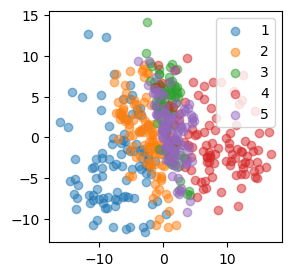

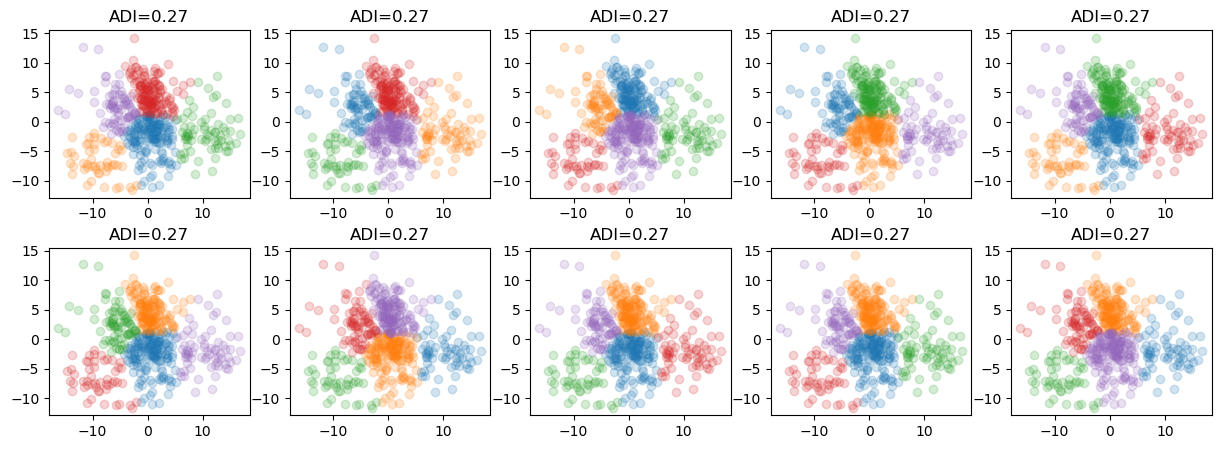

In [64]:
test_clustering_stability(res_cvae_5type_N1000_2D,do_plot=True)

5 subtypes, N=2000, NDIM:2 : M=0.58,SD=0.01,0.57-0.59,ΔACC=0.03


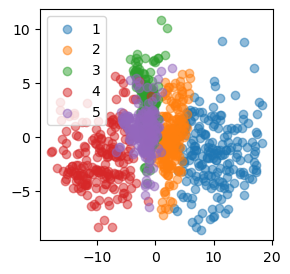

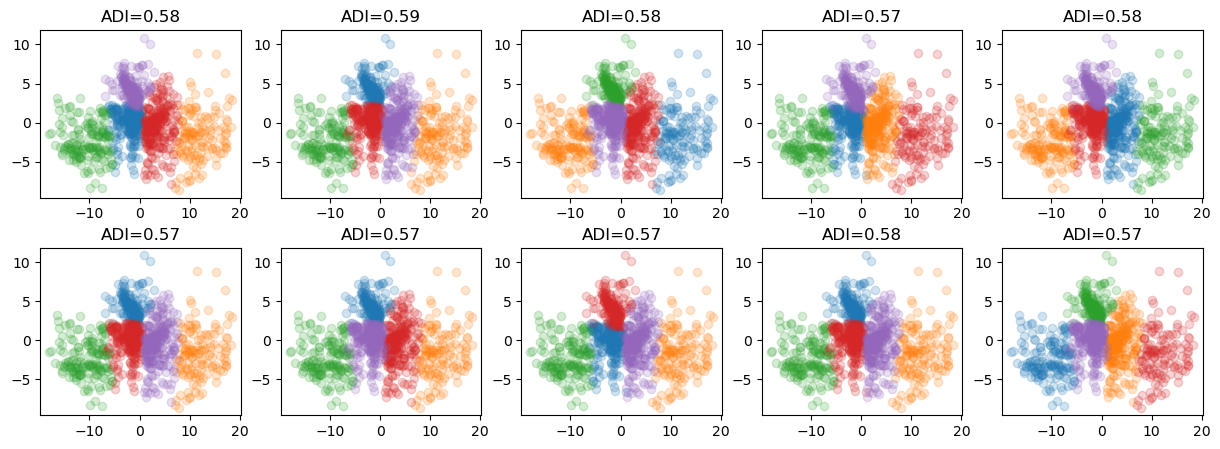

In [65]:
test_clustering_stability(res_cvae_5type_N2000_2D,do_plot=True)

In [66]:
def plot_brain(mat):
    #mat = mat-mat[0,0,0]
    #mat = (mat-mat.min()) / (mat.max()-mat.min())
    #mat = (mat-mat.mean()) / mat.std()
    #vmin = mat.min()*.25
    #vmax = mat.max()*.75
    mat = mat.astype(np.float32)
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    #print((mat.min(),mat.max()))
    #print(mat[0,0,0])
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1);plt.imshow(np.rot90(mat[:,:,32]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,2);plt.imshow(np.rot90(mat[:,32,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,3);plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)

In [67]:
def get_neurosubtypes(df,data,latent_features,diffs=None):
    import itertools
    #df = pd.read_csv('../Data/synth-data-02.csv')
    #print(df.shape)
    patients = df['dx'].values==1
    controls = df['dx'].values==0
    subtype = df.iloc[patients]['subtype'].values
    isubtypes = np.unique(subtype)
    nsubtypes = len(isubtypes)
    nsubtypes
    
    #data = np.load('../Data/synth-data-02.npy').astype(np.float16)
    #print(data.shape)
    
    #latent_features = res_vae['latents_stacked']
    
    gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]
    gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])
    
    res = {}
    res['C'] = []
    res['gt_subtypes'] = gt_subtypes.astype(np.float32)
    res['data_subtypes'] = []
    res['corr_vec'] = []
    res['corr_vec_optimal'] = []
    res['data_subtypes_sorted'] = []
    
    def get_perm_corr(perm1,perm2,gt_subtypes,data_subtypes):
        #corrs = np.array([np.corrcoef(gt_subtypes[perm1[i],:,:,:].flatten(),data_subtypes[perm2[i],:,:,:].flatten())[0,1] for i in range(len(perm1))])

        corrs = []
        for i in range(len(perm1)):
            vec1 = gt_subtypes[perm1[i],:,:,:].flatten()
            vec2 = data_subtypes[perm2[i],:,:,:].flatten()
            #idx = np.vstack((vec1,vec2)).sum(axis=0)!=0
            idx = vec1!=0
            corr = np.corrcoef(vec1[idx],vec2[idx])[0,1]
            corrs.append(corr)
        corrs = np.array(corrs)

        
        corr_avg = corrs.mean()
        return corr_avg,corrs
    
    for rep in tqdm(np.arange(5)):
        #C = GaussianMixture(n_components=nsubtypes).fit_predict(latent_features[rep,:,:])
        C = KMeans(n_clusters=nsubtypes).fit_predict(latent_features[rep,:,:])

        if type(diffs)==type(None): # If VAE data
            data_subtypes = np.array([data[patients,:,:,:].mean(axis=0)-data[patients,:,:,:][C==i,:,:,:].mean(axis=0) for i in np.unique(C)])
        else:
            data_subtypes = np.array([diffs[C==i,:,:,:].mean(axis=0) for i in np.unique(C)])

        permutations = np.array(list(itertools.permutations(np.arange(nsubtypes))))
        perm1 = np.arange(nsubtypes)
        corr_vec = np.array([get_perm_corr(perm1,permutations[i,:],gt_subtypes,data_subtypes)[0] for i in range(len(permutations))])
        get_perm_corr(perm1,permutations[np.argmax(corr_vec),:],gt_subtypes,data_subtypes)
        data_subtypes_sorted = data_subtypes[permutations[np.argmax(corr_vec),:],:,:,:]
        
        res['C'].append( C )
        res['data_subtypes'].append( data_subtypes.astype(np.float32) )
        res['corr_vec'].append( corr_vec )
        res['corr_vec_optimal'].append( get_perm_corr(perm1,permutations[np.argmax(corr_vec),:],gt_subtypes,data_subtypes) )
        res['data_subtypes_sorted'].append( data_subtypes_sorted.astype(np.float32) )
    print(res.keys())
    return res

### Get Neurosubtype Data

In [68]:
df = pd.read_csv('../Data/synth-data-02-N1000.csv')
data = np.load('../Data/synth-data-02-N1000.npy').astype(np.float16)
latent_features = vae_res_N1000['latents_stacked']	

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 12)
(1000, 64, 64, 64)
(5, 500, 80)


In [69]:
neurosubtypes_vae_N1000 = get_neurosubtypes(df,data,latent_features,diffs=None)

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [70]:
df = pd.read_csv('../Data/synth-data-02.csv')
data = np.load('../Data/synth-data-02.npy').astype(np.float16)
latent_features = vae_res_N2000['latents_stacked']	

print(df.shape)
print(data.shape)
print(latent_features.shape)

(2000, 11)
(2000, 64, 64, 64)
(5, 1000, 72)


In [71]:
neurosubtypes_vae_N2000 = get_neurosubtypes(df,data,latent_features,diffs=None)

100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.13s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [72]:
df = pd.read_csv('../Data/synth-data-02-N1000.csv')
data = np.load('../Data/synth-data-02-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-02-N1000.npy').astype(np.float16)[0:500]
latent_features = res_cvae_N1000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(diffs.shape)
print(latent_features.shape)

(1000, 12)
(1000, 64, 64, 64)
(500, 64, 64, 64)
(5, 500, 40)


In [73]:
neurosubtypes_cvae_2_N1000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [74]:
df = pd.read_csv('../Data/synth-data-02.csv')
data = np.load('../Data/synth-data-02.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-02-N2000.npy').astype(np.float16)
latent_features = res_cvae_N2000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(diffs.shape)
print(latent_features.shape)

(2000, 11)
(2000, 64, 64, 64)
(1000, 64, 64, 64)
(5, 1000, 40)


In [75]:
neurosubtypes_cvae_2_N2000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [76]:
df = pd.read_csv('../Data/synth-data-03-N1000.csv')
data = np.load('../Data/synth-data-03-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-03.npy').astype(np.float16)[0:500]
latent_features = res_cvae_3type_N1000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 14)
(1000, 64, 64, 64)
(5, 500, 40)


In [77]:
neurosubtypes_cvae_3_N1000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [78]:
df = pd.read_csv('../synth-data-03/data_description.csv')
data = np.load('../synth-data-03/data.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-03.npy').astype(np.float16)
latent_features = res_cvae_3typeN2000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(2000, 13)
(2000, 64, 64, 64)
(5, 1000, 40)


In [79]:
neurosubtypes_cvae_3_N2000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [80]:
df = pd.read_csv('../Data/synth-data-05-N1000.csv')
data = np.load('../Data/synth-data-05-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float16)[0:500]
latent_features = res_cvae_5type_N1000_2D['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 14)
(1000, 64, 64, 64)
(5, 500, 40)


In [81]:
neurosubtypes_cvae_5_N1000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [82]:
df = pd.read_csv('../synth-data-05/data_description.csv')
data = np.load('../synth-data-05/data.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float16)
latent_features = res_cvae_5type_N2000_2D['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(2000, 13)
(2000, 64, 64, 64)
(5, 1000, 40)


In [83]:
neurosubtypes_cvae_5_N2000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


### Plot neurosubtype data

In [84]:
plot_data = neurosubtypes_vae
title = 'VAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

NameError: name 'neurosubtypes_vae' is not defined

In [ ]:
plot_data = neurosubtypes_vae_N2000
title = 'VAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_2_N1000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_2_N2000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_3_N1000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_3_N2000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_5_N1000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [ ]:
plot_data = neurosubtypes_cvae_5_N2000
title = 'CVAE'
n = len(plot_data['C'][0])*2
nc = len(np.unique(plot_data['C'][0]))
for i in range(nc):
    plot_brain(plot_data['gt_subtypes'][i,:,:,:])
    if i==0: plt.suptitle(title+', N={}, nC={}'.format(n, nc),y=.75);
    plot_brain(plot_data['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

### Neurosubtype stats

In [ ]:
df = pd.read_csv('../synth-data-05/data_description.csv')
data = np.load('../synth-data-05/data.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float16)
latent_features = res_cvae_5type_N2000_2D['s_latents_stacked']

In [ ]:
r_m = [] 
r_indiv = []
for i in range(10):
    temp = get_neurosubtypes(df,data,latent_features,diffs)
    r_m.append(temp['corr_vec_optimal'][0][0] )
    r_indiv.append( temp['corr_vec_optimal'][0][1] )
r_m = np.array(r_m)
r_indiv = np.array(r_indiv)

In [ ]:
print(r_indiv.min(axis=0).round(3))
print(r_indiv.max(axis=0).round(3))
print(r_indiv.std(axis=0).round(3))

In [ ]:
#neurosubtypes_vae_N1000
#neurosubtypes_vae_N2000
#neurosubtypes_cvae_2_N1000
#neurosubtypes_cvae_2_N2000
#neurosubtypes_cvae_3_N1000
#neurosubtypes_cvae_3_N2000
#neurosubtypes_cvae_5_N1000
#neurosubtypes_cvae_5_N2000

In [ ]:
neurosubtypes_cvae_5_N2000.keys()

In [ ]:
def print_neurosubtype_corr(data,modelname='VAE'):
    corr_avg = np.array([val[0] for val in data['corr_vec_optimal']])
    corr_indiv = np.array([val[1] for val in data['corr_vec_optimal']])
    str_avg = corr_avg.mean().round(2)
    str_indiv = ' '.join([f'S{i+1} {corr_indiv[:,i].mean():.2f}' for i in range(corr_indiv.shape[1])])
    n = len(data['C'][0])*2 
    nc = len(np.unique(data['C'][0]))
    print(f'Correlation with ground truth: {modelname} N={n}, Nc={nc}: avg {str_avg} indiv | {str_indiv}')

In [ ]:
print_neurosubtype_corr(neurosubtypes_vae_N1000,modelname='VAE')
print_neurosubtype_corr(neurosubtypes_vae_N2000,modelname='VAE')

In [ ]:
print_neurosubtype_corr(neurosubtypes_cvae_2_N1000,modelname='CVAE')
print_neurosubtype_corr(neurosubtypes_cvae_2_N2000,modelname='CVAE')
print('___')
print_neurosubtype_corr(neurosubtypes_cvae_3_N1000,modelname='CVAE')
print_neurosubtype_corr(neurosubtypes_cvae_3_N2000,modelname='CVAE')
print('___')
print_neurosubtype_corr(neurosubtypes_cvae_5_N1000,modelname='CVAE')
print_neurosubtype_corr(neurosubtypes_cvae_5_N2000,modelname='CVAE')

In [ ]:
print('CVAE > VAE N1000')
vec1 = [val[0] for val in neurosubtypes_cvae_2_N1000['corr_vec_optimal']]
vec2 = [val[0] for val in neurosubtypes_vae_N1000['corr_vec_optimal']]

print('Average')
pretty_t_ind(vec1,vec2)

print('Individual')
vec1 = np.array([val[1] for val in neurosubtypes_cvae_2_N1000['corr_vec_optimal']])
vec2 = np.array([val[1] for val in neurosubtypes_vae_N1000['corr_vec_optimal']])
[pretty_t_ind(vec1[:,i],vec2[:,i]) for i in range(2)];

In [ ]:
vec1 = [val[0] for val in neurosubtypes_cvae_2_N2000['corr_vec_optimal']]
vec2 = [val[0] for val in neurosubtypes_cvae_2_N1000['corr_vec_optimal']]
pretty_t_ind(vec1,vec2)

In [ ]:
vec1 = [val[0] for val in neurosubtypes_cvae_3_N2000['corr_vec_optimal']]
vec2 = [val[0] for val in neurosubtypes_cvae_3_N1000['corr_vec_optimal']]
print((np.array(vec1).mean()-np.array(vec2).mean()).round(3))
pretty_t_ind(vec1,vec2)

In [ ]:
vec1 = [val[0] for val in neurosubtypes_cvae_5_N2000['corr_vec_optimal']]
vec2 = [val[0] for val in neurosubtypes_cvae_5_N1000['corr_vec_optimal']]
pretty_t_ind(vec1,vec2)